<a href="https://colab.research.google.com/github/zahraDehghanian97/Brain_cancer_classification/blob/master/Brain_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Section1:*Colab Introductory Commands*

####We review and execute some of the required commands here.
####These commands are mainly used to assign necessary accesses and specify and construct directories.

In [1]:
# #Connect Google Drive to Colab

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# #Drive REST API and authenticate

# from google.colab import auth
# auth.authenticate_user()

In [3]:
# #List Files and Directories

# !ls -a
# !ls "/content/drive/My Drive/Colab Notebooks" -a

In [4]:
# #Change dir
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Brain Cancer')
# !ls

In [5]:
# #Create a directory named dataset
# !mkdir dataset
# !ls -a

##Section2:*Uploading and extracting data sets*

####We download our relatively large dataset directly and then extract and organize it.

In [6]:
# #Download Files
# from google.colab import files
# import requests 
# file_url = "https://ndownloader.figshare.com/articles/1512427/versions/5"
	
# r = requests.get(file_url, stream = True) 

# with open("/content/drive/My Drive/Colab Notebooks/Brain Cancer/data.zip", "wb") as file: 
# 	for block in r.iter_content(chunk_size = 1024): 
# 		if block: 
# 			file.write(block) 


In [7]:
# ##Unzip data
# !unzip -q data.zip -d dataset/


In [8]:
# ##Extract All zip
# import os, zipfile
# os.chdir('/content/drive/My Drive/Colab Notebooks/Brain Cancer/dataset')

# #for filenames in os.walk('/dataset/'):
# #  for filename in filenames:
# #    !unzip -q filename -d filename/

# #Method1: Extract All zip in 1 Folder
# dir_name = '/content/drive/My Drive/Colab Notebooks/Brain Cancer/dataset'
# Extract_dir_name1 = '/content/drive/My Drive/Colab Notebooks/Brain Cancer/dataset/A'

# for item in os.listdir(dir_name): # loop through items in dir
#     if item.endswith(".zip"): # check for ".zip" extension
#         file_name = os.path.abspath(item) # get full path of files
#         print (file_name) #Print zip file Name
#         zip_ref = zipfile.ZipFile(file_name) # create zipfile object
#         zip_ref.extractall(Extract_dir_name1) # extract file to Extract dir
#         zip_ref.close() # close file
#         os.remove(file_name) # delete zipped file


##Section3:*Import Necessary Basic Libraries Required*

####We Import Tenserflow , keras ,Numpy ,Pandas ,Matplotlib and Other Necessary Library and its Modules.

In [11]:
# Import Necessary Library

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

import gc
import cv2
import time
import zipfile
import glob, os
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa

import h5py
import keras
from keras.layers import *
from keras.callbacks import *
from keras import backend as K
from keras.models import Model
from keras.applications import *
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.applications.nasnet import NASNetMobile, preprocess_input
tf.__version__

'2.9.2'

##Section4:Loading and Preparing data.

###Here, while addressing the data and reading it, we perform some operations such as resizing using Nampy and CV2.

###Next We Define Input Arrays and Image Data Frame.


In [12]:
##Loade Images by H5py
os.chdir('/content/drive/My Drive/Colab Notebooks/Brain Cancer/dataset')
img=np.zeros((3064,224,224))
label=[]

#Method1: Read All Image of "A" Directory 
for i in range(1,3065):
  path='A/'
  with h5py.File(path+str(i)+'.mat') as f:
    images = f['cjdata']
    resized = cv2.resize(images['image'][:,:], (224,224), interpolation = cv2.INTER_CUBIC )
    x=np.asarray(resized)
    x=(x-np.min(x))/(np.max(x)-np.min(x))
    x=x.reshape((1,224,224))
    img[i-1]=x
    label.append(int(images['label'][0]))

In [13]:
#Define Input Array

path='/content/drive/My Drive/Colab Notebooks/Brain Cancer/dataset/cvind.mat'
with h5py.File(path) as f:
      data=f['cvind']
      idx=data[0]
import scipy.io
obj_arr = {}
obj_arr['images'] = img
obj_arr['label'] = label
obj_arr['fold']=idx
np.save('check.npy', obj_arr)

In [14]:
#Create Images Data Frame

path = F"check.npy" 
df=np.load(path,allow_pickle=True)
df=df.item()
df['images']=df['images'].astype(np.float32)

##Section5:Image Data Functions.

###We Define the Required Functions such as Training and Testing of data Preparation as well as Aggregation.

In [15]:
##Function definition

#Splits
def Splits(df,test_fold):
  dimension=224
  idx=np.asarray(df['fold'])
  y=np.asarray(df['label'])
  y-=1
  img=np.asarray(df['images'])
  img1=[]
  for i in range(len(img)):
        img1.append(Resizing(img[i]))
  img1=np.asarray(img1)
  del([img])
  gc.collect()
  train_y=np.asarray(y[(idx!=test_fold)])
  train_img=np.asarray(img1[(idx!=test_fold)])
  test_y=np.asarray(y[(idx==test_fold)])
  test_img=img1[idx==test_fold]
  dimension=224
  train_img=np.repeat(train_img.reshape((train_img.shape[0],dimension,dimension,1)),3,axis=3)
  test_img=np.repeat(test_img.reshape((test_img.shape[0],dimension,dimension,1)),3,axis=3)
  return (train_img.copy(),train_y.copy()),(test_img.copy(),test_y.copy())

#shuffle images
def Shuffle(a, b):
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  return a[p], b[p]

#Resize images
def Resizing(img):
  dimension=224
  resized = cv2.resize(img, (dimension,dimension), interpolation = cv2.INTER_AREA )
  return resized

In [16]:
##Define Augmentation Functions

#Noise
def Noise(images):
    ms=[]
    for i in images:
        x = np.random.normal(loc=0, scale=0.05, size=(dimension,dimension,3))
        ms.append(i+x)
    return ms

#Horizontal Flips
def Horizontal( images):
		seq = iaa.Sequential([iaa.Fliplr(1.0)])
		return seq.augment_images(images)

#Vertical Flips
def Vertical( images):
		seq = iaa.Sequential([iaa.Flipud(1.0)])
		return seq.augment_images(images)

#Rotate Images
def Rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

#Rotate
def Rotate(images):
    ms=[]
    for angle in range(-15,20,5):
        for image in images:
            ms.append(Rotate_image(image,angle))
    return ms

##Section6:Image Data Generator.

###Define the Generator Function to Present Data to the Learning Model.

In [17]:
#Generator

class DataGenerator(keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
    self.labels     = labels              # array of labels
    self.images     = images              # array of image paths
    self.batch_size = batch_size          # batch size
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(self.labels.shape[0] / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(self.labels.shape[0])

  def __getitem__(self, index):
		# selects indices of data for next batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    # select data and load images
    labels = self.labels.loc[indexes]
    img = [self.images[k].astype(np.float32) for k in indexes]
    imgH=Horizontal(img)
    imgV=Vertical(img)
    imgR=Rotate(img)
    images=[]
    images.extend(imgH)
    images.extend(imgV)
    images.extend(imgR)
    label=labels.copy()
    labels=pd.DataFrame()
    labels=pd.concat([labels,label],0)
    labels=pd.concat([labels,label],0)
    labels=pd.concat([labels,label],0)
    labels=pd.concat([labels,label],0)
    labels=pd.concat([labels,label],0)
    labels=pd.concat([labels,label],0)
    labels=pd.concat([labels,label],0)
    labels=pd.concat([labels,label],0)
    labels=pd.concat([labels,label],0)
    return np.asarray(images), labels

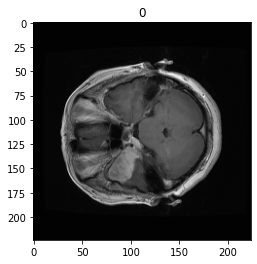

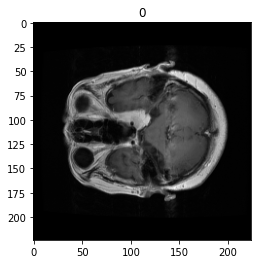

In [18]:
#Shuffle Train and Test
index = 2
train,test=Splits(df,index)
train_x,train_y=Shuffle(train[0],train[1])
test_x,test_y=Shuffle(test[0],test[1])

#Show Sample

plt.imshow(train[0][0])
plt.title(train[1][0])
plt.show()
plt.imshow(test[0][0])
plt.title(test[1][0])
plt.show()

##Section7:Model and Parameters.

###Create Model and Setting Its Parameters.

In [19]:
##Define Model1

from keras.applications import ResNet50
from keras.applications import ResNet50V2
def load_model(last=True):
  K.clear_session()

  #loading Resnet50 model
  mod=ResNet50(include_top=True, weights='imagenet')
  out_1=mod.layers[-2]
  out=Dense(3,activation='softmax')(out_1.output)
  model=Model(inputs=mod.input,outputs=out)
  if last:
    for i in range(len(model.layers)):
        model.layers[i].trainable = False
  model.layers[-1].trainable=True
  return model
model=load_model(last=False)

102967424/102967424 [==============================] - 5s 0us/step


In [21]:
#Set Model Parameters
fold = 2
best=0
index=2
epoch=50
pre_acc=0
times_last={}
answers_last={}
history_last={}
predictions_last={}
history_last[fold]=0
best_accuracy_last={}
final_accuracy_last={}
fold='fold_'+str(index)
predictions_last_best={}
train,test=Splits(df,index)

es=EarlyStopping(monitor='loss',patience=5,mode='min')
def upd(dk,data):
  if dk==0:
    dk=data
  else:
    for ky in data.keys():
      dk[ky].extend(data[ky])
  return dk

##Section8:Model Compile and Information.

###We compile Model and get Model Layers Information.

In [22]:
#Compiling the Model

model.compile(optimizer=Adam(6e-5,decay=0,clipnorm=1.0),loss='categorical_crossentropy',metrics=['accuracy'])
train_data = DataGenerator(train_x,pd.get_dummies(train_y), batch_size=4, augment=True)

In [23]:
#Model Information

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

##Section9:Fit Model and Train It.

###Now We Fit model and Define Training Result variables.
###waiting for Model result Next Save It.

In [24]:
##Fitting the model

#Time
start=time.time()
history_last=model.fit_generator(train_data,epochs=epoch,validation_data=[test_x,to_categorical(test_y)],steps_per_epoch=len(train_x)//4,callbacks=[es])
pre=model.predict(test_x)
pre=np.argmax(pre,1)  
end=time.time()
times_last[fold]=end-start

#Prediction 
pre=model.predict(test_x)
  
#Maximum position
pre=np.argmax(pre,1)
predictions_last[fold]=pre
  
#Accuracy
new_acc=accuracy_score(pre,test_y)

#Saving Predictions
final_accuracy_last[fold]=new_acc

#Saving Answers
answers_last[fold]=test_y
    
#Clear Memory
del([train,test,train_x,train_y,test_x,test_y])
gc.collect()

<ipython-input-24-2f90a6bc186b>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_last=model.fit_generator(train_data,epochs=epoch,validation_data=[test_x,to_categorical(test_y)],steps_per_epoch=len(train_x)//4,callbacks=[es])
<ipython-input-17-70268c32874c>:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  labels=pd.concat([labels,label],0)
<ipython-input-17-70268c32874c>:32: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  labels=pd.concat([labels,label],0)
<ipython-input-17-70268c32874c>:33: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  labels=pd.concat([labels,label],0)
<ipython-input-17-70268c32874c>:34: FutureWarning: In a future version of pandas all ar

Epoch 1/50
596/596 [==============================] - 262s 398ms/step - loss: 0.2973 - accuracy: 0.8919 - val_loss: 2.0127 - val_accuracy: 0.4978
Epoch 2/50
596/596 [==============================] - 243s 407ms/step - loss: 0.0560 - accuracy: 0.9803 - val_loss: 0.5507 - val_accuracy: 0.8527
Epoch 3/50
596/596 [==============================] - 242s 406ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.1997 - val_accuracy: 0.9337
Epoch 4/50
596/596 [==============================] - 242s 406ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.3733 - val_accuracy: 0.9470
Epoch 5/50
596/596 [==============================] - 242s 407ms/step - loss: 7.7656e-04 - accuracy: 0.9999 - val_loss: 0.2343 - val_accuracy: 0.9499
Epoch 6/50
121/596 [=====>........................] - ETA: 3:11 - loss: 1.9982e-04 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [ ]:
##Fitting the model

start=time.time()                               #Time
history_last=model.fit_generator(train_data,epochs=epoch,validation_data=[test_x,to_categorical(test_y)],steps_per_epoch=len(train_x)//4,callbacks=[es])
pre=model.predict(test_x)
pre=np.argmax(pre,1)  
end=time.time()
times_last[fold]=end-start 
pre=model.predict(test_x)                       #Prediction
pre=np.argmax(pre,1)                            #Maximum position
predictions_last[fold]=pre
new_acc=accuracy_score(pre,test_y)              #Accuracy
final_accuracy_last[fold]=new_acc               #Saving Predictions
answers_last[fold]=test_y                       #Saving Answers
del([train,test,train_x,train_y,test_x,test_y]) #Clear Memory
gc.collect()